In [77]:
using DrWatson
using Pkg
@quickactivate "toysector"
using CSV, DelimitedFiles, HypothesisTests, BSON, Distributions, Random 
using SpinModels, Optim, Parameters, CUDA, LinearAlgebra, Statistics, Printf, Flux
using BenchmarkTools, PyPlot
import StatsBase.countmap
import DrWatson.savename

include( srcdir( "fitting.jl"   ) )
include( srcdir( "toysector.jl" ) )
include( srcdir( "false_positive_funcs.jl" ) )
include( srcdir( "samplers.jl"             ) )
include( srcdir( "aisZ.jl" ))

trace! (generic function with 1 method)

In [123]:
function get_froJ(J::AbstractArray{T,4} ,p::Real=2) where T<:Number
    N = size(J,2)
    froJ= [ norm(J[:,i,:,j], p) for i ∈ 1:N, j ∈ 1:N ] 
end

function get_froh(h::AbstractMatrix{T} ,p::Real=2) where T<:Number
    N = size( h,2 )
    froh = [ norm(h[:,i], p) for i ∈ 1:N ]
end

function get_froW(W::AbstractArray{T,3}, p::Real=2) where T<:Number
    P, _, N = size(W)
    froW = [ norm(W[μ,:,i],p) for μ ∈ 1:P, i ∈ 1:N  ]
end

function get_fro(A::AbstractArray, p::Real=2)
    ndims(A) == 2 && return get_froh(A,p)
    ndims(A) == 3 && return get_froW(A,p)
    ndims(A) == 4 && return get_froJ(A,p) 
end

im20(mat)= im20( mat,  begin _, ax = subplots(); ax end )
function im20(mat, ax)
    im = ax.imshow(mat )

    dimy, dimx = size(mat)
    
    stepx = round(dimx/10) == 0 ? 1 : Int(round(dimx/10))
    stepy = round(dimy/10) == 0 ? 1 : Int(round(dimy/10))
    
    # Major ticks
    ax.set_xticks(0:stepx:dimx-1)
    ax.set_yticks(0:stepy:dimy-1)

    # Labels for major ticks
    ax.set_xticklabels(1:stepx:dimx)
    ax.set_yticklabels(1:stepy:dimy)

    # Minor ticks
    ax.set_xticks(-.5:1:dimx, minor=true)
    ax.set_yticks(-.5:1:dimy, minor=true)

    # # Gridlines based on minor ticks
    # minorticks_off()
    (dimx < 50) && (dimy < 50) ? ax.grid(true, which="minor", color="k", linestyle="-", linewidth=1.5) : nothing
#     colorbar()\
    sca(ax)
    tick_params(bottom = false, left = false, which = "both")
    
    return im
end

im35(mat)= im35( mat,  begin _, ax = subplots(); ax end,  )
function im35(mat, ax, cmap="cividis", hideticklabels=false)
    im = ax.imshow(mat, cmap=cmap )

    dimy, dimx = size(mat) 
    stepx = round(dimx/10) == 0 ? 1 : Int(round(dimx/10))
    stepy = round(dimy/10) == 0 ? 1 : Int(round(dimy/10))

    ax.set_xticks([0,9,28,34])
    ax.set_yticks([0,9,28,34])
    ax.set_xticklabels( [1,10,29,35],  fontsize=16 )
    ax.set_yticklabels( [1,10,29,35],  fontsize=16 )
    
    ax.tick_params(bottom = false, left = false, which = "both")
    
    ax.set_xticks(-.5:1:dimx, minor=true)
    ax.set_yticks(-.5:1:dimy, minor=true)
    (dimx < 50) && (dimy < 50) ? ax.grid(true, which="minor", 
        color="k", linestyle="-", linewidth=0.5) : nothing
    
    
    if hideticklabels == false
        ax.xaxis.set_tick_params(labeltop=true)
        ax.xaxis.set_tick_params(labelbottom=false)
    else
        ax.yaxis.set_tick_params(labelleft=false)
        ax.xaxis.set_tick_params(labelbottom=false)
    end
    
   
    
    # Major ticks
    # ax.set_xticks(0:stepx:dimx-1)
    # ax.set_yticks(0:stepy:dimy-1)
    # # Labels for major ticks
    # ax.set_xticklabels(1:stepx:dimx)
    # ax.set_yticklabels(1:stepy:dimy)  
    
    ax.vlines([10,28].-0.5, -0.5, dimy-0.5, colors="white", linewidth=2)
    ax.hlines([10,28].-0.5, -0.5, dimx-0.5, colors="white", linewidth=2)
    return im
end


im35 (generic function with 4 methods)

# define models to import

In [125]:
folds = 5
seed = 123
Random.seed!(seed)
calc_f_pos = true
nsamples_for_fpos = 10_000;
calc_H = true

q,N = (5,35)

(5, 35)

In [126]:
samples_to_fit_all = Dict{Symbol, Any}(
    :M => [500], #nsamples
#     :T_sec => [0.2, 0.25, 0.3, 0.4, 0.5, 0.6]  
    :T_sec => [1.,0.4, 0.2],
    :m => [1,2,3]
    )

modls = [:Pairwise]# , :RBM]#, :SRBM]

params_sets = Dict{Symbol,Any}(
        :Pairwise => Dict{Symbol, Any}(
        :reg_J => [(10f0^log10λ, 2) for log10λ ∈ -8:1],
        :reg_h => [(10f0^log10λ, 2) for log10λ ∈ 2:2],
        :epochs => 20_000,
        :showevery => 500,
        :progTol => 10^-6
    )
     # ,
     #     :RBM => Dict{Symbol, Any}(
     #     :reg_W => [(10f0^log10λ, 2) for log10λ ∈ -8:-1],
     #     :reg_h => [(10f0^log10λ, 2) for log10λ ∈ -4:2],
     #     :P => [10,20,30,40,50],
     #     :epochs => 20_000,
     #     :showevery => 500,
     #     :progTol => 10^-6
     # )
#     ,
#     :SRBM => Dict{Symbol, Any}(
#         :reg_J => [(10f0^log10λ, 2) for log10λ ∈ -6:-1],
#         :reg_W => [(10f0^log10λ, 2) for log10λ ∈ -8:-1],
#         :reg_h => [(10f0^log10λ, 2) for log10λ ∈ -4:2],
#         :P => collect(10:20:50),
#         :epochs => 20_000,
#         :showevery => 50,
#         :progTol => 10^-6
#     )
)

samples_to_fit_dict_list = dict_list(samples_to_fit_all)

9-element Vector{Dict{Symbol, Real}}:
 Dict(:m => 1, :M => 500, :T_sec => 1.0)
 Dict(:m => 2, :M => 500, :T_sec => 1.0)
 Dict(:m => 3, :M => 500, :T_sec => 1.0)
 Dict(:m => 1, :M => 500, :T_sec => 0.4)
 Dict(:m => 2, :M => 500, :T_sec => 0.4)
 Dict(:m => 3, :M => 500, :T_sec => 0.4)
 Dict(:m => 1, :M => 500, :T_sec => 0.2)
 Dict(:m => 2, :M => 500, :T_sec => 0.2)
 Dict(:m => 3, :M => 500, :T_sec => 0.2)

##### helper funcs

In [129]:

# _, θsec =  init_toy_model( Tsec, m=m )

function get_fpos_from_samps(results,θsec)
    z  = results[:z_from_fit]
    H_ = results[:fit_entropy][:entropy]
    E_under_gt = sectorenergy(z[:,29:35,:], θsec, 
        SectorEnergyBuffer(θsec, size(results[:z_from_fit],3)))
    n_fpos = E_under_gt .== Inf32
    # @show n_fpos
    
    f_pos= sum(n_fpos)/length(n_fpos)
    return f_pos, H_
end

get_fpos_from_samps (generic function with 1 method)

In [130]:
function write_ents_f_pos_to_d(Tsec, m, Tsamp, results,d, mdl_str)
    if Tsamp == 1
        θpw, θsec = init_toy_model( Tsec, m=m )
        f_pos, H_= get_fpos_from_samps(results,θsec)
            d[:true_entropy] = H_toymodel( θpw, θsec )[:Htotal]
            d[:false_pos_rate]=f_pos
            d[:fit_entropy]=H_
    end
    BSON.@save mdl_str*".bson" d
end

write_ents_f_pos_to_d (generic function with 2 methods)

# main loop for calcs
warning! runs slow. may need to outsource to cluster

see scripts folder

In [84]:
# for k in 1:length(samples_to_fit_dict_list)

#     samples_to_fit_info=samples_to_fit_dict_list[k]
#     sampledir(args...) = datadir("toysector_q=5", 
#         "nsamples=$(samples_to_fit_info[:M])", args...)

#     fitsdir(args...) = sampledir("fitted_models", 
#         @sprintf("sector_temp=%.2f_m=%i", 
#             samples_to_fit_info[:T_sec], samples_to_fit_info[:m]), 
#         args...)

#     Tsec, m = (samples_to_fit_info[:T_sec], samples_to_fit_info[:m])

#     sweep_dicts = Dict{Symbol, Any}()

#     Tsamps = collect(1:-0.1:0.1)
#     # Tsamps = [0.1, 0.2, 0.3]


#     ##### NOTHING BELOW HERE SHOULD BE EDITED #####
#     option_ais =OptionAIS(
#             anneal_steps=10, #1000
#             showevery=50, 
#             chains=10, #5000
#             gibbs=false,
#             silent=false,
#             samplingDict=Dict(:traceevery=>1, :stopafter=>50, :max_sampling_steps=>2000),#1000
#             gpu = CUDA.functional() 
#         )

#     @printf("GETTING ENTS AT DIFF T FOR MODELS FIT TO DATA FOR Tsec = %.2f and m=%i\n", 
#             samples_to_fit_info[:T_sec], samples_to_fit_info[:m])
    
#     ### make containers for in-sample and estimated out-of-sample loss for each model's sweep over hyperparams
#     sweep_dicts = Dict{Symbol, Any}()
#     for mdl in modls
#         sweep_dicts[mdl] = dict_list( params_sets[mdl] )
#     end

#     @show CUDA.functional()
#     ### for each model type (pairwise, rbm, sRBM)
#     for mdl in modls
#         mdldir(args...) = fitsdir(string(mdl), args...)

#         # swp_ds_string = mdldir( string(mdl)*"_best_results.bson")

#         ### do hyperparam sweep
#         swp_ds =  sweep_dicts[mdl] #alias
#         @printf "\n"
#         @printf "Begin calculations of H and frac_func of %s model\n" string(mdl)
#     #     d = swp_ds[job_id]
#         for d in swp_ds
#             @printf "\n"
#             @printf "-----------------------------------------------\n"
#             @printf "%s\n" savename(d)

#             P = haskey(d, :P) ? d[:P] : 0
#             θ = initθ(mdl, q, N, P)

#             mdl_str = mdldir(savename(d))

#             if isfile( mdl_str*".bson" )
#                 @printf "model alrealy fit. loading into memory\n"
#             else
#                 @error "model $(mdl_str) not found." 
#             end
#             merge!(d, BSON.load(mdl_str*".bson")[:d])


#             BSON.@load mdl_str*"_model.bson" vecθ
#             copyto!(θ, vecθ)

#             @printf "-----------------------------------------------\n"

#             ###calculate entropy
#             @show typeof(θ)
#             for Tsamp in Tsamps
#                 # check if samples file already exists
#                 smpl_str=mdldir(savename(d)*"_samples_T=$(Tsamp).bson")
#                 if isfile(smpl_str)
#                     # re-write any arrays that cu-arrays into regular arrays
#                     results = BSON.load(smpl_str)[:results]
#                     z_from_fit=results[:z_from_fit]
#                     results[:z_from_fit] = collect(z_from_fit)
#                     BSON.@save mdldir(savename(d)*"_samples_T=$(Tsamp).bson") results
#                     @printf "samples at T=%f already exist for %s. skipping\n" Tsamp savename(d)

#                     # if Tsamp == 1, put ent and fpos into the corresponding model dict
#                     write_ents_f_pos_to_d(Tsec, m, Tsamp, results,d, mdl_str)

#                     continue
#                 end

#                 @printf "calculating entropy for T = %f\n" Tsamp 

#                 ais_trace, fit_entropy, z_from_fit = calc_H ? begin
#                     ais_trace, ais_result, z_from_fit = AISlogZ(θ, option_ais, Tsamp)
#                     @show ais_result
#                     (ais_trace, ais_result, z_from_fit)
#                 end : (nothing, nothing, nothing)

#             #         calc_frac_func && ( @printf "frac_func = %f" frac_func )
#             #         @printf "\n"

#                 z_from_fit = collect(z_from_fit)

#                 ### put results in dictionary
#                 results = Dict{Symbol, Any}(
#                         :z_from_fit => z_from_fit, :ais_trace=>ais_trace,
#                         :fit_entropy => fit_entropy )
                
#                 _, θsec = init_toy_model( Tsec, m=m )
#                 f_pos, H_= get_fpos_from_samps(results,θsec)
                
#                 write_ents_f_pos_to_d(Tsec, m, Tsamp, results,d, mdl_str)
                
#                 results[:f_pos] = f_pos
                
#                 BSON.@save mdldir(savename(d)*"_samples_T=$(Tsamp).bson") results
#             end

#         end
#         #also save the vector of dictionaries with results
#     #     BSON.@save swp_ds_string swp_ds
#     end
# end

# @printf "finished!" 

GETTING ENTS AT DIFF T FOR MODELS FIT TO DATA FOR Tsec = 1.00 and m=1
CUDA.functional() = false

Begin calculations of H and frac_func of Pairwise model

-----------------------------------------------
L2_regh=1e2.0_regJ=1e-8.0
model alrealy fit. loading into memory
-----------------------------------------------
typeof(θ) = Pairwise{Matrix{Float32}, Array{Float32, 4}}
calculating entropy for T = 1.000000
         i    Zᵦᵢ/Zᵦ₍ᵢ₋₁₎  mean(Eᵦ₍ᵢ₋₁₎)  std(Eᵦ₍ᵢ₋₁₎)    rate  time (s)  sample steps
----------  ------------  -------------  -----------   ------  --------  ------------
ais_result = Dict{Symbol, Any}(:T => 1.0f0, :logZ => 78.314545f0, :entropy => 26.171204f0, :meanE => -52.14334f0)
calculating entropy for T = 0.900000
         i    Zᵦᵢ/Zᵦ₍ᵢ₋₁₎  mean(Eᵦ₍ᵢ₋₁₎)  std(Eᵦ₍ᵢ₋₁₎)    rate  time (s)  sample steps
----------  ------------  -------------  -----------   ------  --------  ------------
ais_result = Dict{Symbol, Any}(:T => 0.9f0, :logZ => 84.87277f0, :entropy => 26.206207f0, :mea

LoadError: InterruptException:

# process data and plot

In [431]:
samples_to_fit_all

Dict{Symbol, Any} with 3 entries:
  :m     => [1, 2, 3]
  :M     => [500]
  :T_sec => [1.0, 0.4, 0.2]

### specify experiments to import

In [432]:
M=500 #number of training data
Tsec=0.4 # 0.4 in paper
m=3 # 3 in paper

3

### import

In [433]:


modls = [:Pairwise ]#, :RBM]#, :SRBM]
params_sets = Dict{Symbol,Any}(
    :Pairwise => Dict{Symbol, Any}(
        :reg_J => [(10f0^log10λ, 2) for log10λ ∈ -8:1],
        :reg_h => [(10f0^log10λ, 2) for log10λ ∈ 2:2],
        :epochs => 20_000,
        :showevery => 500,
        :progTol => 10^-6
    )
     # ,
     # :RBM => Dict{Symbol, Any}(
     #     :reg_W => [(10f0^log10λ, 2) for log10λ ∈ -8:-1],
     #     :reg_h => [(10f0^log10λ, 2) for log10λ ∈ 2:2],
     #     :P => [50],
     #     :epochs => 20_000,
     #     :showevery => 500,
     #     :progTol => 10^-6
     # )
)

sampledir(args...) = datadir("toysector_q=5", 
    "nsamples=$(M)", args...)

z = BSON.load(
    sampledir( @sprintf("sector_temp=%.2f_m=%i_samples.bson", Tsec, m) ) 
    )[:samples];
z = Float32.(z)
q,N,_=size(z)

(5, 35, 500)

In [436]:
fitsdir(args...) = sampledir("fitted_models", @sprintf("sector_temp=%.2f_m=%i", Tsec, m)
    , args...)
plotsdir_curr(args...)=plotsdir(@sprintf("sector_temp=%.2f_m=%i", Tsec, m),
    args... )

mkpath(plotsdir_curr())

"/Users/pfields/Git/toysector/plots/sector_temp=0.40_m=3"

In [435]:
sweep_dicts = Dict{Symbol, Any}()
for mdl in modls
    sweep_dicts[mdl] = dict_list( params_sets[mdl] )
end
    

### for each model type (pairwise, rbm, sRBM)
for mdl in modls
    mdldir(args...) = fitsdir(string(mdl), args...)
    isdir(mdldir()) || mkpath(mdldir())
    swp_ds = sweep_dicts[mdl] #alias
    @printf "\n"
    @printf "%s model\n" string(mdl)
    for d in sweep_dicts[mdl]
        # name = savename(d)*"_2"
        name = savename(d)
        
        @printf "%s\n" mdldir(name*".bson")
        # @show isfile(mdldir(name*".bson"))
	    if isfile(mdldir(name*".bson"))
            vecθ = BSON.load(mdldir(name*"_model.bson"))[:vecθ]
            P = haskey(d, :P) ? d[:P] : 0
            θ = initθ(mdl, q, N, P )
            zerosum!(θ)
            copyto!(θ, vecθ)
            d[:θ] = θ
            merge!(d, BSON.load(mdldir(name*".bson"))[:d])
        end
    end
end


Pairwise model
/Users/pfields/Git/toysector/data/toysector_q=5/nsamples=500/fitted_models/sector_temp=0.40_m=3/Pairwise/L2_regh=1e2.0_regJ=1e-8.0.bson
/Users/pfields/Git/toysector/data/toysector_q=5/nsamples=500/fitted_models/sector_temp=0.40_m=3/Pairwise/L2_regh=1e2.0_regJ=1e-7.0.bson
/Users/pfields/Git/toysector/data/toysector_q=5/nsamples=500/fitted_models/sector_temp=0.40_m=3/Pairwise/L2_regh=1e2.0_regJ=1e-6.0.bson
/Users/pfields/Git/toysector/data/toysector_q=5/nsamples=500/fitted_models/sector_temp=0.40_m=3/Pairwise/L2_regh=1e2.0_regJ=1e-5.0.bson
/Users/pfields/Git/toysector/data/toysector_q=5/nsamples=500/fitted_models/sector_temp=0.40_m=3/Pairwise/L2_regh=1e2.0_regJ=1e-4.0.bson
/Users/pfields/Git/toysector/data/toysector_q=5/nsamples=500/fitted_models/sector_temp=0.40_m=3/Pairwise/L2_regh=1e2.0_regJ=1e-3.0.bson
/Users/pfields/Git/toysector/data/toysector_q=5/nsamples=500/fitted_models/sector_temp=0.40_m=3/Pairwise/L2_regh=1e2.0_regJ=1e-2.0.bson
/Users/pfields/Git/toysector/dat

In [413]:
# sweep_dicts[:Pairwise][1]

### Jij heat maps

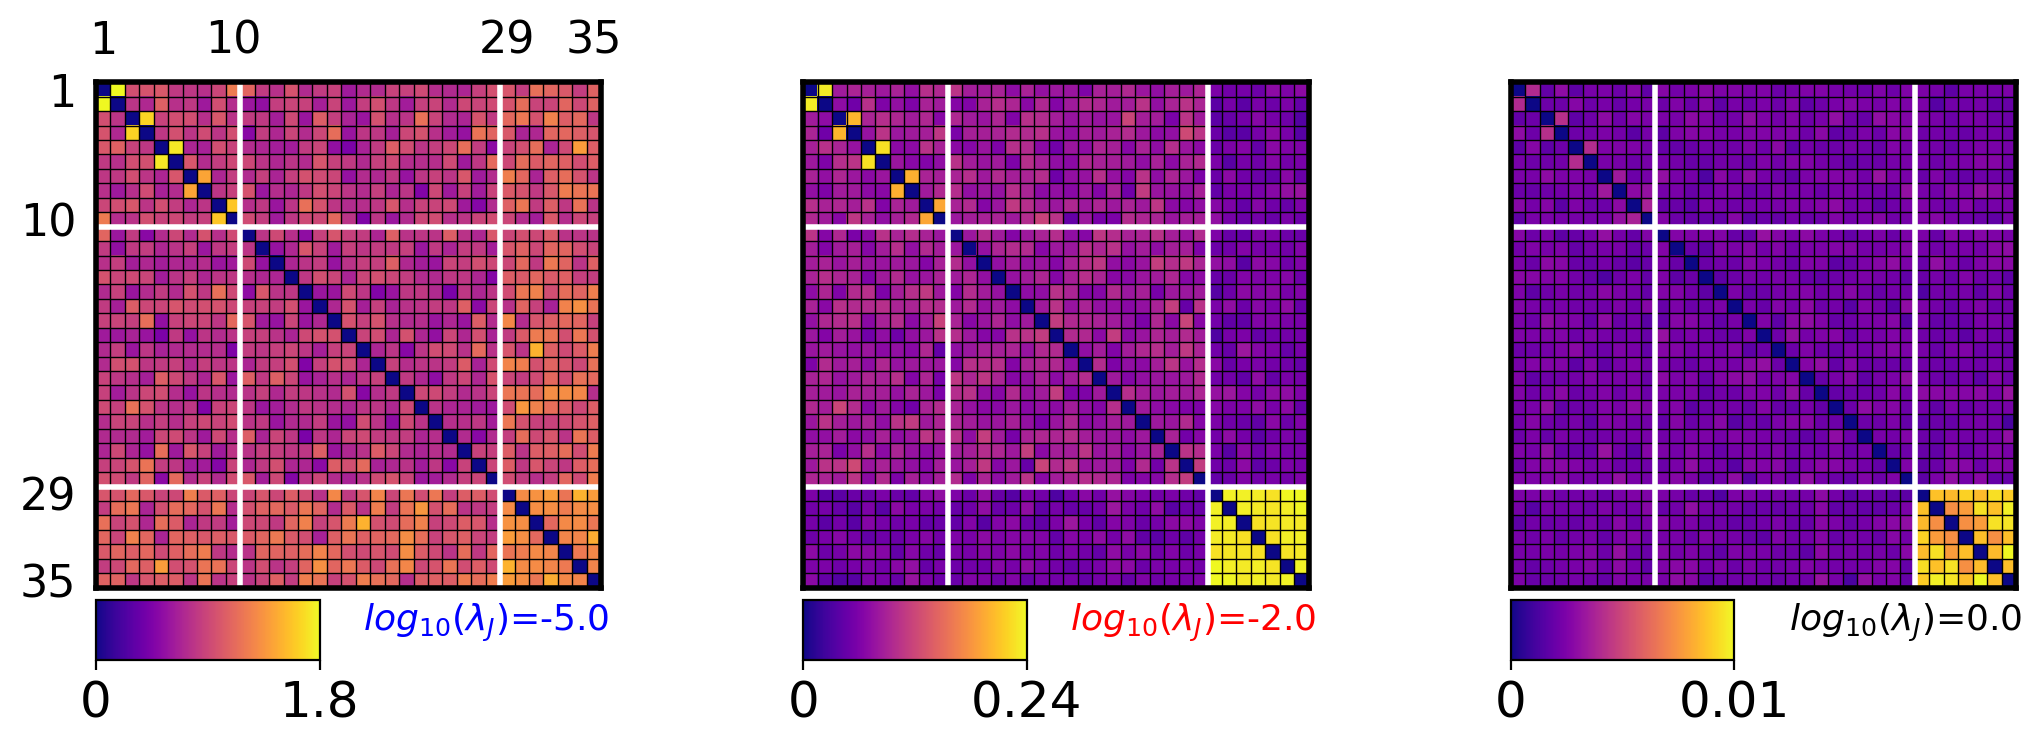

In [414]:
fig, ax = subplots(1,3, dpi=200, figsize=(12,12))
ax=ax[:]
permute!(ax, [1,2,3])

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

i=1
for (d,col) in zip(sweep_dicts[:Pairwise][[4,7,9]], ["blue", "red", "k"])
    im = i ==1 ? im35( get_fro(d[:θ].J),ax[i], "plasma", false) : im35( get_fro(d[:θ].J),
        ax[i], "plasma", true)
    
    # ax[i].set_title("regJ = $(d[:reg_J][1])")
    cax = fig.add_axes([ax[i].get_position().x0, ax[i].get_position().y0-0.03, 
    ax[1].get_position().x1*0.3, 0.025])
    posx, posy = i != 3 ? (18, 37.5) : (18.8, 37.5) 
    # col = i == 2 ? "red" : "k"
    ax[i].text(posx,posy, L"log_{10}(λ_J)"*"=$(log10(d[:reg_J][1]))", fontsize=13, c=col) 
        

    # cbar = colorbar(im, cax=cax, )
    cbar = fig.colorbar(im, cax=cax, orientation="horizontal", ticks=[im.get_clim()...])
    i ==3 ? cbar.ax.set_xticklabels(map( x->@sprintf("%.1g",x), im.get_clim() ), fontsize=18 )  : 
        cbar.ax.set_xticklabels(map( x->@sprintf("%.2g",x), im.get_clim() ), fontsize=18 ) 
    # cbar.ax.set_xticklabels(fontsize=15)
    for axis in ["top","bottom","left","right"]
        ax[i].spines[axis].set_linewidth(2)
    end
    
    # colorbar(im, orientation="horizontal")
    i+=1
    
end

# savefig(plotsdir_curr("fit_Jijs.pdf"))

### pull regs and losses from hyperparameter sweep dicts

In [415]:
losses_pw   = pull_from_sweep(sweep_dicts[:Pairwise], 
    [:reg_h, :reg_J, :mean𝕍] 
    )
best_idx_pw = findmin(losses_pw[:,end])[2]
best_pw_reg_h, best_pw_reg_J, _ = losses_pw[best_idx_pw, :]

to_pull_from_sweep = [:reg_J, :mean𝕍, :std𝕍, :inloss ]

( push!( to_pull_from_sweep, :false_pos_rate ) )
( push!( to_pull_from_sweep, :fit_entropy  ) )

@show to_pull_from_sweep

losses_pw   = pull_from_sweep(sweep_dicts[:Pairwise], 
    to_pull_from_sweep ;
    reg_h = best_pw_reg_h
    )


# note: columns 5 and 6 will be pulled from the ais sample dicts later and replaced

to_pull_from_sweep = [:reg_J, :mean𝕍, :std𝕍, :inloss, :false_pos_rate, :fit_entropy]


10×6 Matrix{Any}:
 (1.0f-8, 2)  1.55749   0.0485824    0.300364  0.9678   4.35333
 (1.0f-7, 2)  1.56266   0.0325405    0.312888  0.9326   4.6839
 (1.0f-6, 2)  1.5238    0.038134     0.30027   0.9692   4.43225
 (1.0f-5, 2)  1.41712   0.0409595    0.322436  0.8756   4.8381
 (0.0001, 2)  1.20289   0.0257646    0.355292  0.3224   4.88962
 (0.001, 2)   0.986615  0.0144791    0.468706  0.0      6.24913
 (0.01, 2)    0.888863  0.00555955   0.692792  0.0     16.208
 (0.1, 2)     0.945845  0.00157405   0.910494  0.1154  44.856
 (1.0, 2)     0.99398   0.000426831  0.992398  0.9798  48.8867
 (10.0, 2)    1.00107   0.0018723    1.00322   0.9976  47.3907

### now create array with temperatures, fpos, and different reg strengths


##### heat map arrays

In [416]:
nsamps_for_ais = 5000 # might be 5000 sometimes

nregs = 10
nsampTs = 10

θpw, θsec =  init_toy_model( Tsec )
sec_energy_buffer = SectorEnergyBuffer(θsec, nsamps_for_ais)

hmap_fpos = zeros(nregs,nsampTs)
hmap_ent = zeros(nregs,nsampTs)
loglambdas = zeros(nregs)
Tsamps = 0.1:0.1:1

allsamps = Matrix{Any}(nothing, nregs, nsampTs)

# samps[k] = BSON.load( fitsdir(savename(d)*"_samples_T=$(Tsamp).bson"))[:results]

for (i,d) in enumerate(sweep_dicts[:Pairwise])
    loglambdas[i] = round(log10(d[:reg_J][1]))
    
    for j in 1:nsampTs
        # get samps for model at given temp
        name = savename(d)
        samplestring="_samples_T=$(Tsamps[j]).bson"
        
        allsamps[i,j] = BSON.load( fitsdir("Pairwise",
                name*samplestring))[:results]
        
        # comment out below after I fix the ais code
        # logZ₀ = sum( log.( sum( exp.( d[:θ].h ), dims=1 )))
        # logZ₀T = sum( log.( sum( exp.( d[:θ].h./Tsamps[j] ), dims=1 )))
        # get entropy estimate
        hmap_ent[i,j] = allsamps[i,j][:fit_entropy][:entropy] #- logZ₀ + logZ₀T
        
        # get false positive rate
        z = allsamps[i,j][:z_from_fit]
        E_under_gt = sectorenergy(z[:,29:35,:], θsec, sec_energy_buffer)
        n_fpos = E_under_gt .== Inf32
        hmap_fpos[i,j] = sum(n_fpos)/length(n_fpos)
    end
end


# for each lambda (row) (low to high)
  # sweep through temps (columns) low to high and populate each heat map

In [417]:
allsamps[1,1][:fit_entropy]

Dict{Symbol, Any} with 4 entries:
  :T       => 0.1
  :logZ    => 686.45
  :entropy => 4.35333
  :meanE   => -68.2097

In [418]:
hmap_ent 

10×10 Matrix{Float64}:
  4.35333   4.88269   6.09436  …  16.8853  20.8298  25.2376  29.4364
  4.6839    5.43967   7.12039     23.3985  28.5064  32.7031  35.9961
  4.43225   4.81247   5.98143     16.6     20.6882  25.2805  29.0411
  4.8381    5.98534   8.29637     28.7736  33.0648  36.5116  39.2234
  4.88962   7.38612  12.4118      38.2765  41.3857  43.8115  45.6835
  6.24913  15.0419   27.0382   …  48.4883  50.5633  51.8635  52.754
 16.208    35.5721   43.2632      55.0705  55.4033  55.6102  55.7913
 44.856    54.7667   55.7944      56.2395  56.2645  56.28    56.2871
 48.8867   54.2722   55.4528      56.1574  56.1956  56.2305  56.2532
 47.3907   53.5351   55.0279      56.0693  56.1365  56.17    56.1973

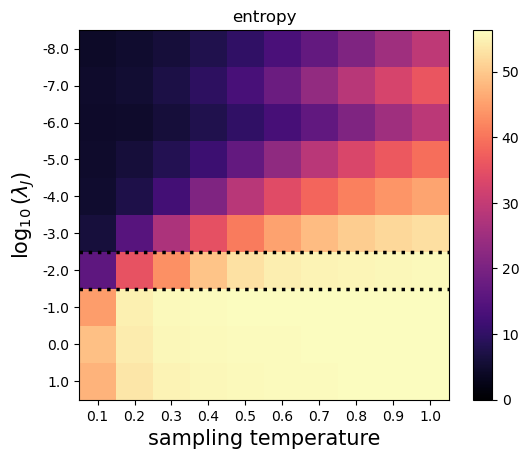

PyObject <matplotlib.collections.LineCollection object at 0x38fd5b740>

In [419]:
fig, ax = subplots(dpi=100)

im=imshow(hmap_ent, cmap="magma")
clim(0,35*log(5))
colorbar()
ax=gca()
ax.set_yticks(collect(0:9))
ax.set_yticklabels(loglambdas)
ax.set_xticks(collect(0:9))
ax.set_xticklabels(collect(Tsamps))
ax.set_title("entropy")
ax.set_ylabel(L"\log_{10}(\lambda_J)", fontsize=15)
ax.set_xlabel("sampling temperature", fontsize=15)




ax.hlines(6.5,-0.5,9.5, color="k", linestyle="dotted", linewidth=2.5)
ax.hlines(5.5,-0.5,9.5, color="k", linestyle="dotted", linewidth=2.5)

In [420]:
hmap_fpos;

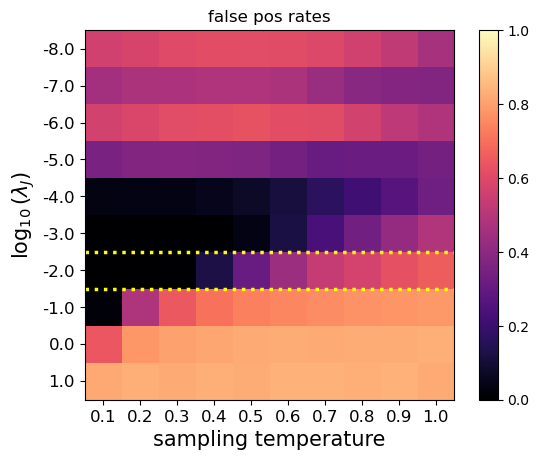

PyObject <matplotlib.collections.LineCollection object at 0x3cad678f0>

In [421]:
fig, ax = subplots(dpi=100)


imshow(hmap_fpos, cmap="magma")
colorbar()
clim(0,1)
ax=gca()
ax.set_ylabel(L"\log_{10}(\lambda_J)", fontsize=15)
ax.set_xlabel("sampling temperature", fontsize=15)
ax.set_yticks(collect(0:9))
ax.set_yticklabels(loglambdas, fontsize=12)
ax.set_xticks(collect(0:9))
ax.set_xticklabels(collect(Tsamps), fontsize=12)

ax.set_title("false pos rates")

ax.hlines(6.5,-0.5,9.5, color="yellow", linestyle="dotted",linewidth=2.5)
ax.hlines(5.5,-0.5,9.5, color="yellow", linestyle="dotted",linewidth=2.5)

### make plots of f_pos vs entropy for diffent fixed T or regJ

sys:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
sys:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


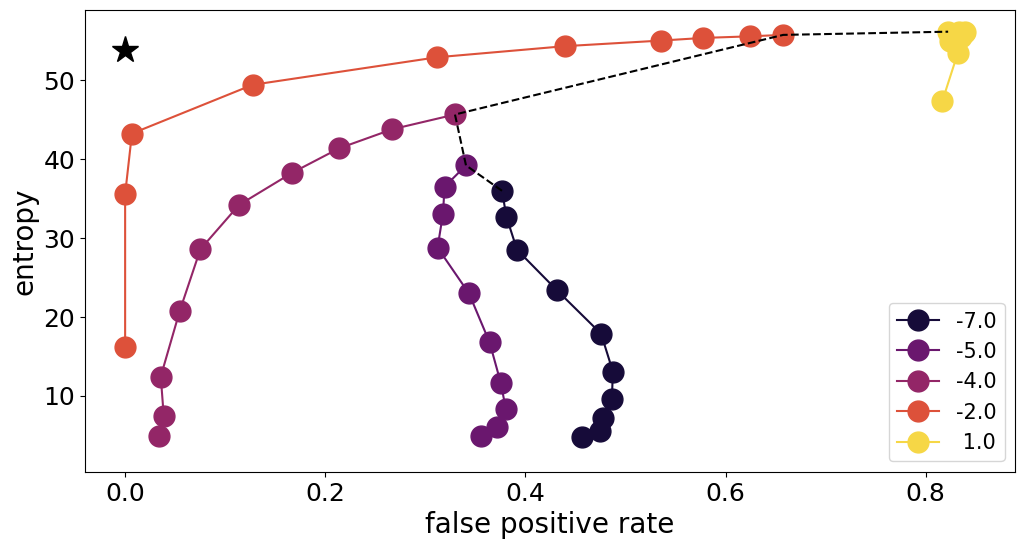

In [422]:
# fix a given lambda change T
fig, ax = subplots(figsize = (12,6), dpi=100)

function ent_vs_fpos(ax)
startT_idx=1
lastT_idx = 10
# ll =loglambdas
iddxxs = [2, 4,5,7,10]
ll = [ -8, -7.0, -6, -5.0, -4.0, -3, -2.0, -1.0, 0.0, 1]
zorders = [2,3,4,5,6,7,8,1,9,10]
lpl = 1

c = ColorMap("inferno")(collect(range(0,0.9,10)))
for i in iddxxs
    logλ = ll[i]
    row_idx = findall(loglambdas .== logλ)
    row_idx = row_idx[1]
    ccc =  logλ == -2 ? "red" : c[i,:]
    ccc =c[i,:]
    if logλ <= lpl 
        # c =  logλ == 2 ? "red" : c[i,:]
        msize = logλ == -2 ? 15 : 15
        label = logλ > -1 ? " $logλ" : "$logλ"
        ax.plot( hmap_fpos[row_idx,startT_idx:lastT_idx], hmap_ent[row_idx,startT_idx:lastT_idx], 
        "-", label=label, c=ccc, markersize=msize, marker="o",zorder=zorders[i])
    else 
        ax.plot( hmap_fpos[row_idx,lastT_idx:lastT_idx], hmap_ent[row_idx,lastT_idx:lastT_idx], 
        "-", label=label, c=ccc, markersize=10, marker="o", zorder=zorders[i])
    end
end
ax.legend(loc="lower right", fontsize=15, frameon=true)
ax.set_ylabel("entropy", fontsize=20)
ax.set_xlabel("false positive rate", fontsize=20)
ax.set_xlim(-0.040075000000000006, 0.8892416666666666)
ax.set_ylim(0.32441342507015714, 58.98683932302265)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

ax.plot( hmap_fpos[iddxxs,10], hmap_ent[iddxxs,10], 
        "--", label="T=1", c="k", alpha=1, zorder=20, markersize=5)

ax.plot(0, H_toymodel(init_toy_model(Tsec)...)[:Htotal], "k*", markersize=20)
# ax.text(0.01, 1.5+H_toymodel(init_toy_model(Tsec)...)[:Htotal], "ground truth", )
# ax.set_title("varying T for fixed lambdas")
end

ent_vs_fpos(ax)

# savefig(plotsdir_curr("fpos_vs_ent.pdf"))

### energy histograms of training data and model samples

In [423]:
z_synth = BSON.load(
    sampledir( @sprintf("sector_temp=%.2f_m=%i_samples.bson", Tsec, m) ) 
    )[:samples];
z_synth = Float32.(z_synth);

In [424]:
Enatural_permodel = Vector{Any}(nothing, length(loglambdas))
for k in 1:length(loglambdas)
    @show sweep_dicts[:Pairwise][k][:reg_J]
    Enatural_permodel[k] = energy(z_synth, sweep_dicts[:Pairwise][k][:θ] )
end

((sweep_dicts[:Pairwise])[k])[:reg_J] = (1.0f-8, 2)
((sweep_dicts[:Pairwise])[k])[:reg_J] = (1.0f-7, 2)
((sweep_dicts[:Pairwise])[k])[:reg_J] = (1.0f-6, 2)
((sweep_dicts[:Pairwise])[k])[:reg_J] = (1.0f-5, 2)
((sweep_dicts[:Pairwise])[k])[:reg_J] = (0.0001f0, 2)
((sweep_dicts[:Pairwise])[k])[:reg_J] = (0.001f0, 2)
((sweep_dicts[:Pairwise])[k])[:reg_J] = (0.010000001f0, 2)
((sweep_dicts[:Pairwise])[k])[:reg_J] = (0.1f0, 2)
((sweep_dicts[:Pairwise])[k])[:reg_J] = (1.0f0, 2)
((sweep_dicts[:Pairwise])[k])[:reg_J] = (10.0f0, 2)


In [425]:
all_Esamps = Matrix{Any}(nothing, nregs, nsampTs)

for i in 1:length(loglambdas)
    @show sweep_dicts[:Pairwise][i][:reg_J]
    θ = sweep_dicts[:Pairwise][i][:θ] 
    for j in 1:length(Tsamps)
        # @show size(allsamps[i,j][:z_from_fit])
        all_Esamps[i,j] = energy( allsamps[i,j][:z_from_fit] , θ )
    end
end

((sweep_dicts[:Pairwise])[i])[:reg_J] = (1.0f-8, 2)
((sweep_dicts[:Pairwise])[i])[:reg_J] = (1.0f-7, 2)
((sweep_dicts[:Pairwise])[i])[:reg_J] = (1.0f-6, 2)
((sweep_dicts[:Pairwise])[i])[:reg_J] = (1.0f-5, 2)
((sweep_dicts[:Pairwise])[i])[:reg_J] = (0.0001f0, 2)
((sweep_dicts[:Pairwise])[i])[:reg_J] = (0.001f0, 2)
((sweep_dicts[:Pairwise])[i])[:reg_J] = (0.010000001f0, 2)
((sweep_dicts[:Pairwise])[i])[:reg_J] = (0.1f0, 2)
((sweep_dicts[:Pairwise])[i])[:reg_J] = (1.0f0, 2)
((sweep_dicts[:Pairwise])[i])[:reg_J] = (10.0f0, 2)


Tsamps[k] = 1.0
Tsamps[k] = 0.7
Tsamps[k] = 0.4
Tsamps[k] = 0.2


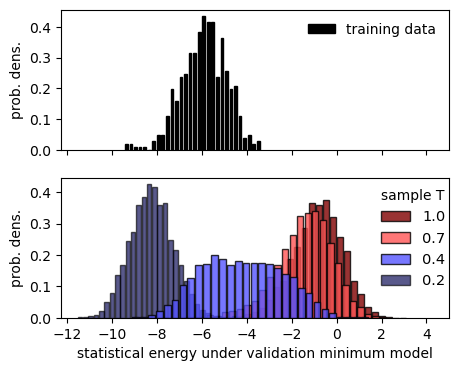

In [426]:
fig, (ax, ax2) = subplots(2,1, dpi=100, figsize=(5,4), sharex=true )
c = ColorMap("seismic")(collect(range(0,1,length(all_Esamps[:,1]))))

logλ = -2

row_idx = findall(loglambdas .== logλ)

Tsamps = collect(0.1:0.1:1)
for (k, cidx,zorder) in zip([10,7,4,2], [10,7,4,1], [1,2,4,3])
    alpha = k == 2 ? 0.65 : 0.8
    im = ax2.hist( all_Esamps[row_idx, k], color=c[cidx,:], density=true, bins=30, ec="k",
        alpha=alpha, rwidth=0.85, label="$(Tsamps[k])", zorder=zorder)
    @show Tsamps[k]
end


# ax2.
ax.hist( Enatural_permodel[row_idx] , color="k", 
    density=true, bins=30, ec="k", rwidth=0.6, label="training data");
ax.legend(frameon=false)
ax2.set_xlabel("statistical energy under validation minimum model")
ax.set_ylabel("prob. dens.")
ax2.set_ylabel("prob. dens.")
ax2.set_xlim(ax2.get_xlim()[1], 5)
ax2.legend(loc=(0.81,0.17),fontsize=10.5, frameon=false, title="sample T")

# if logλ == -2
#     suptitle("statistical energy under validation minimum model")
# else
#     suptitle("logλ = $logλ")
# end

# savefig(plotsdir_curr("energy_hists.pdf"))

### f_pos and ent vs sampling temp

In [427]:
function plot_all(ax, xlims, ylims, xxlabel, ax1label, calc_ent, x, ents, rand_ent, true_ent)
    c1="chocolate"
    ax.set_ylim(ylims)
    # ax.set_ylabel( ax1label, fontsize=20, c=c1)
    ax.set_xlim(xlims)
    ax.set_xlabel(xxlabel, fontsize=20)
    ax.tick_params(axis="y", labelcolor=c1, color=c1)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
    ax.spines["left"].set_color(c1)
    ax.spines["left"].set_linewidth(2)
    ax.spines["right"].set_linewidth(0)
    ax.spines["top"].set_linewidth(0)
    ax.spines["bottom"].set_linewidth(2)
    ax.set_ylabel( "false positive rate" , color=c1, fontsize=20 ) 
    if calc_ent==true

        ax2 = ax.twinx()
        c2 = "darkmagenta"
        ax2.plot(x, ents, color=c2, zorder=0, linewidth= 3)
        ax2.set_ylabel( "entropy (nats)" , color=c2, fontsize=20)
        # ax2.set_ylim(0,rand_ent+3)
        ax2.tick_params(axis="y", labelcolor=c2)
        ax2.hlines(rand_ent, ax2.get_xlim()...,
            label="random sequence", linestyle="dashed", linewidth=2, color=c2)
        ax2.hlines(true_ent, ax2.get_xlim()...,
            label="ground truth", linestyle="dotted", linewidth=2, color=c2)

        ax2.legend(loc="lower right", frameon=false, labelcolor=c2, fontsize=16)
        ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=20)
        ax2.spines["right"].set_color(c2)
        ax2.spines["left"].set_color(c1)
        ax2.spines["left"].set_linewidth(2)
        ax2.spines["right"].set_linewidth(2)
        ax2.spines["top"].set_linewidth(0)
        ax2.spines["bottom"].set_linewidth(2)
    end
end


plot_all (generic function with 1 method)

sys:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
sys:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
sys:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
sys:1: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


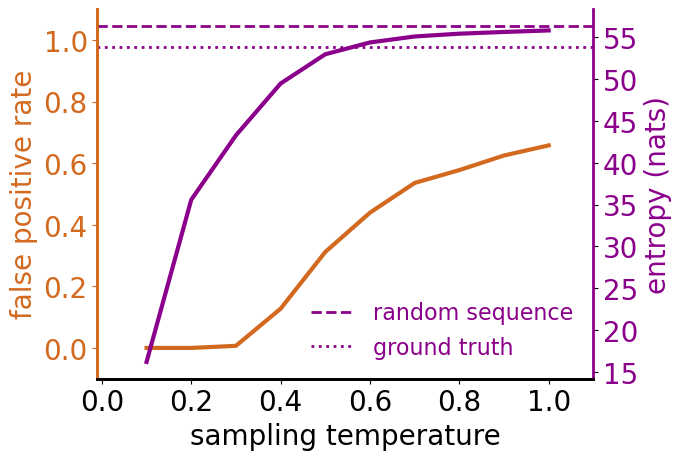

PyObject <matplotlib.legend.Legend object at 0x3cb0c1910>

In [428]:
fig,ax =subplots(dpi=100)
xlims = (-0.01,1.1)
ylims = (-0.1,1.1)
xxlabel = "sampling temperature"
ax1label = "false positive rate" 
sss = collect(1:10)
x = Tsamps[sss]
calc_ent = true
rand_ent = 35*log(5)
true_ent = H_toymodel(init_toy_model(Tsec)...)[:Htotal]
# ents = H

plot_all(ax, xlims, ylims, xxlabel, ax1label, calc_ent, x, 
    hmap_ent[7,:][sss], rand_ent, true_ent)
ax.plot(x, hmap_fpos[7,:][sss], color= "chocolate", linewidth=3)
ax.legend(frameon=false)

### loss, f_pos, and ent versus reg strength lambda_J

In [429]:
function plot_losses_only( ax, losses, rand_ent, ylims, true_ent;
    c1 ="chocolate", c2="darkmagenta")
    lambdas = map(y -> log10(y), map( y -> y[1]  , losses[:,1])) 

    
    ax.errorbar( lambdas , losses[:,2], yerr = losses[:,3],
        label = "mean validation loss", linestyle=":", color=c1, capsize=3, linewidth=3)
    ax.plot(lambdas, losses[:,4], label = "training loss", color=c1 , linewidth=3)
    # ax.grid( alpha=0.5 )
    # linestyle="dashed"
    
    ax.set_ylim( ylims )
    ax.set_ylabel( "loss" , color=c1, fontsize=20 )
    
    ax.tick_params(axis="y", labelcolor=c1, color=c1)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
    # ax.set_xticks([])
    ax.spines["left"].set_color(c1)
    ax.spines["left"].set_linewidth(2)
    ax.spines["right"].set_linewidth(0)
    ax.spines["top"].set_linewidth(0)
    ax.spines["bottom"].set_linewidth(2)
    
    
end

function plot_ent_fpos(ax, losses, rand_ent, ylims, true_ent;
    c1 ="chocolate", c2="darkmagenta", calc_H=true, calc_f_pos=true)
    
    lambdas = map(y -> log10(y), map( y -> y[1]  , losses[:,1]))
    
    calc_f_pos && ( ax.plot( lambdas, losses[:,5] , label = "false positive rate", 
            linestyle="solid", color=c1, linewidth=3, zorder=0) ;
        ax.set_ylabel( "false positive rate" , color=c1, fontsize=20 ) )
    
    ax.set_ylim( ylims )
    ax.tick_params(axis="y", labelcolor=c1, color=c1)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
    ax.spines["left"].set_color(c1)
    ax.spines["left"].set_linewidth(2)
    ax.spines["right"].set_linewidth(0)
    ax.spines["top"].set_linewidth(0)
    ax.spines["bottom"].set_linewidth(2)
    # ax.legend(frameon=false, loc="lower right") 
    
    if calc_H==true

        ax2 = ax.twinx()
        ax2.plot(lambdas, losses[:,6], color=c2, zorder=0, linewidth= 3)
        
        ax2.set_xlim(ax.get_xlim()...)
        ax2.set_ylabel( "entropy (nats)" , color=c2, fontsize=20)
        ax2.tick_params(axis="y", labelcolor=c2)
        ax2.hlines(rand_ent, ax2.get_xlim()...,
            label="random sequence", linestyle="dashed", linewidth=2, color=c2)
        ax2.hlines(true_ent, ax2.get_xlim()...,
            label="ground truth", linestyle="dotted", linewidth=2, color=c2)
        
        # ax2.legend(loc="lower right", frameon=false, labelcolor=c2)
        ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=20)
        ax2.spines["right"].set_color(c2)
        ax2.spines["left"].set_color(c1)
        ax2.spines["left"].set_linewidth(2)
        ax2.spines["right"].set_linewidth(2)
        ax2.spines["top"].set_linewidth(0)
        ax2.spines["bottom"].set_linewidth(2)
    end
end



plot_ent_fpos (generic function with 1 method)

sys:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
sys:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
sys:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
sys:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
sys:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


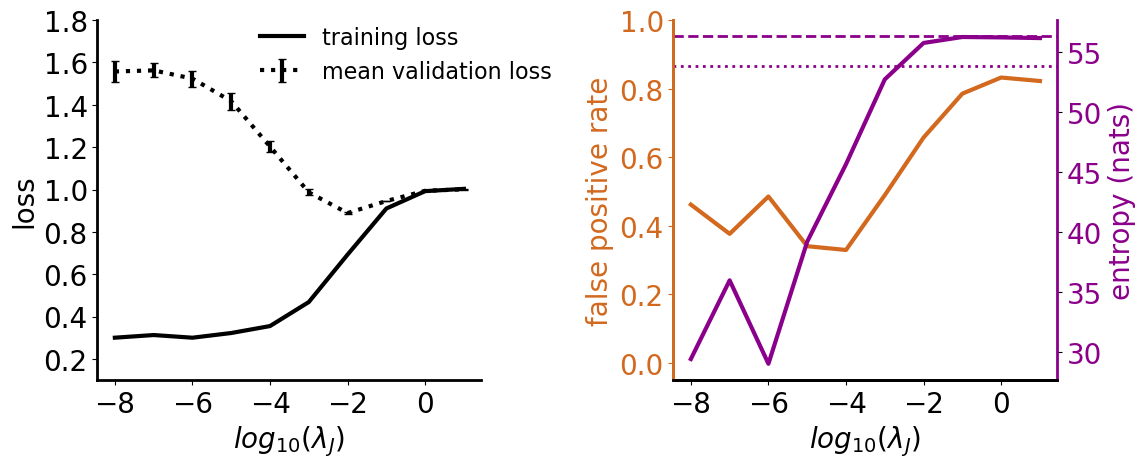

In [430]:
losses_pw[:,6] = hmap_ent[:,10]
losses_pw[:,5] = hmap_fpos[:,10]

fig = figure(dpi=100, figsize=(12,6))
ax1 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, sharex = ax1)


plt.subplots_adjust(left=0.1,
                    bottom=0.2,
                    right=0.9,
                    top=0.8,
                    wspace=0.5,
                    hspace=0.3)
rand_ent=35*log(5)
true_ent = H_toymodel(init_toy_model(Tsec)...)[:Htotal]

ylims =( 0.1,1.8 )
plot_losses_only( ax1, losses_pw, rand_ent, ylims, true_ent; 
        c1="k")

ylims =( -0.05,1. )
plot_ent_fpos( ax3, losses_pw, rand_ent, ylims, true_ent )


ax1.set_xlabel(L"log_{10}(\lambda_J)" , fontsize=20)
ax1.legend(frameon=false, loc=(0.4,0.8), fontsize=16)

ax3.set_xlabel(L"log_{10}(\lambda_J)" , fontsize=20)
# ax3.hlines(true_ent, ax.get_xlim()... , label="true ent", color="darkmagenta", linestyle="dotted",
 # linewidth=3)
# ax3.legend(loc="lower right")

# savefig(plotsdir_curr("loss_ent_fpos_vs_regJ.pdf"))